In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits, ascii

In [20]:
# You may have to download this map and it will take a long time. See dustmaps documentation.
import dustmaps.bayestar

In [4]:
def distmod_to_dist(distmod):
    return 10**(1 + distmod / 5)
# Change modulus to distance

In [5]:
# Load the Bayestar 19 dustmap
b19 = dustmaps.bayestar.BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.809 s
  pix_info:   0.653 s
   samples:  12.350 s
      best:   7.305 s
       nan:   0.107 s
      sort:   5.225 s
       idx:   0.170 s


In [9]:
# Coordinates to be called from Bayestar 2019
l = 105
b = 2

In [12]:
# Function to call coordinates and return distance axis and differential Av. To get total Av along a line a sight try np.sum(cdusts)*delta(dists).

def dust(l, b):
    # Return distance, differential Av along a line of sight provided:
    dists = np.linspace(100, 15000, 100)
    cdusts = np.zeros_like(dists)
    for i, d in enumerate(dists):
        if (i != 0): 
            point = SkyCoord(l*u.deg, b*u.deg, distance=d*u.pc, frame='galactic')
            data, flags = b19.query(point, mode='mean', return_flags=True)
            cdusts[i]=data
    dists = dists/1000
    cdusts = cdusts-np.roll(cdusts, 1)
    return dists, cdusts

(0.0, 10.0)

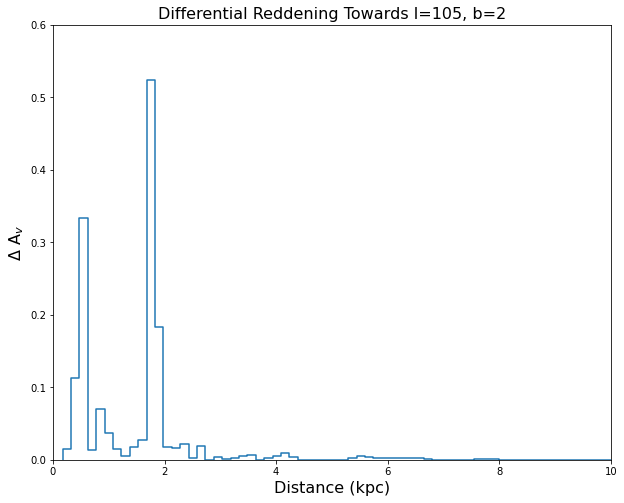

In [13]:
# Grab the kpc, Av data for a given point:
dists, cdusts = dust(l,b)

# Plot the given point:
fig, axs = plt.subplots(1, figsize=(10, 8), sharex='all')

# Plot the Dust:
axs.step(dists, cdusts, where='mid')
axs.set_xlabel('Distance (kpc)', size=16)
axs.set_ylabel(r'$\Delta$ A$_{v}$', size=16)
axs.set_title("Differential Reddening Towards l=105, b=2", size=16)
axs.set_ylim([0, 0.6])
axs.set_xlim([0, 10])

In [14]:
# Change path to OH data:
OHdata = ascii.read('105000p2000_67i.ascii', data_start=1500, data_end=6100, names=['Vel. (km/s)', 'Ta (K)'])
vel = OHdata['Vel. (km/s)']
Ta = OHdata['Ta (K)']

In [15]:
igood = np.where((vel >= -100) & (vel <= 50))

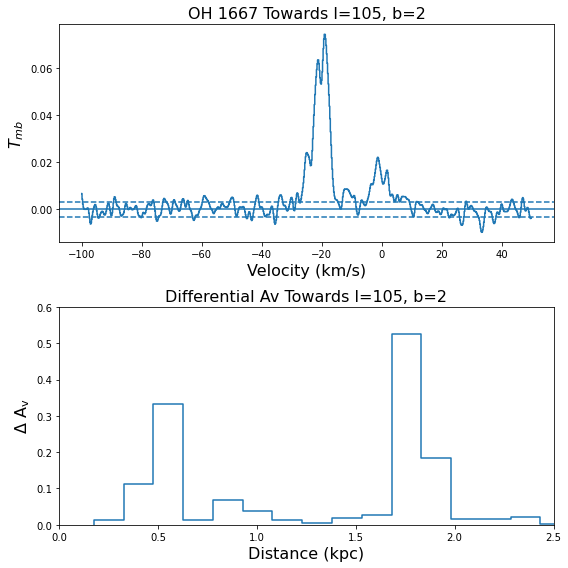

In [19]:
fig, axs = plt.subplots(2, figsize=(8, 8))

# Plot the OH:
axs[0].step(vel[igood], Ta[igood], where='mid')
axs[0].set_xlabel('Velocity (km/s)', size=16)
axs[0].set_ylabel(r'$T_{mb}$', size=16)
axs[0].axhline(0)
axs[0].axhline(0.003, ls='dashed')
axs[0].axhline(-0.003, ls='dashed')
axs[0].set_title("OH 1667 Towards l=105, b=2", size=16)

# Plot the dust extinction:

axs[1].step(dists, cdusts, where='mid')
axs[1].set_xlabel('Distance (kpc)', size=16)
axs[1].set_ylabel(r'$\Delta$ A$_{\mathrm{v}}$', size=16)
axs[1].set_title("Differential Av Towards l=105, b=2", size=16)
axs[1].set_xlim([0, 2.5])
axs[1].set_ylim([0, 0.6])

fig.tight_layout()
fig.savefig('dustOHexample.png', format='png')